# Multiple Experiment Clustering

### Starting with UMAP visualization 

In [1]:
from read_clustering.variant_call import VariantCall
threshold = 0.5

/Users/andrewbailey/anaconda3/envs/read_clustering/lib/python3.7/site-packages/umap/__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")
/Users/andrewbailey/anaconda3/envs/read_clustering/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [247]:
import umap
import hdbscan
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches

import numpy as np
import pandas as pd
import os
import seaborn as sns
import re

In [12]:
ivt_path = "/Users/andrewbailey/CLionProjects/read_clustering/data/inference/variant_calls/canonical_ivt_round30_alt_canonical_supervised_500_500.model.csv"
cbf5_glu_psu_depletion_path = "/Users/andrewbailey/CLionProjects/read_clustering/data/inference/variant_calls/depletion_cbf5_glu_round30_alt_canonical_supervised_500_500.model.csv"
nop58_glu_2o_depletion_path = "/Users/andrewbailey/CLionProjects/read_clustering/data/inference/variant_calls/depletion_nop58_glu_round30_alt_canonical_supervised_500_500.model.csv"       
native_cbf5_gal_path = "/Users/andrewbailey/CLionProjects/read_clustering/data/inference/variant_calls/native_cbf5_gal_round30_alt_canonical_supervised_500_500.model.csv"
native_nop58_gal_path = "/Users/andrewbailey/CLionProjects/read_clustering/data/inference/variant_calls/native_nop58_gal_round30_alt_canonical_supervised_500_500.model.csv"

file_paths = [ivt_path, cbf5_glu_psu_depletion_path, nop58_glu_2o_depletion_path, native_cbf5_gal_path, native_nop58_gal_path]
labels = ["ivt", "cbf5_glu_psu_depletion", "nop58_glu_2o_depletion", "native_cbf5_gal", "native_nop58_gal"]

'27'

In [268]:
class VariantCalls(VariantCall):
    """Read in variant call file and give access points to various types of data"""
    def __init__(self, file_paths, labels):
        super().__init__(file_paths[0])
        data = []
        for path, label in zip(file_paths, labels):
            data.append(self.load_variant_data(path, label))
        self.data = pd.concat(data, ignore_index=True)
        self.experiments = sorted(labels)
        self.color_map = dict(zip(self.experiments, sns.color_palette("tab10")))

        
    def plot_UMAP_by_label(self, contig, positions, figure_path=None, **other_params):
        data = self.data[(self.data["contig"] == contig) & (self.data['reference_index'].isin(positions))]
        df = data.pivot(index=['read_id', 'label'], columns=['reference_index'], values='prob2')
        X = df.dropna()
        reducer = umap.UMAP()
        umap_results = reducer.fit_transform(X)
        X["umap_result_x"] = umap_results[:, 0]
        X["umap_result_y"] = umap_results[:, 1]
#         predictor = hdbscan.HDBSCAN(min_cluster_size=cluster_size, gen_min_span_tree=True).fit_predict(X)
#         X["predictor"] = predictor
        markers = mpl.markers.MarkerStyle.markers.keys()
        marker = 'o'
        alpha = 0.5
#         colors = ('g', 'r', 'c', 'm', 'y', 'k', 'w', 'b')
        
        plt.figure(figsize=(15, 15))
        for experiment in self.experiments:
            plot_data = X.xs(experiment, level="label")
        #     plt.scatter(plot_data["umap_result_x"].values, plot_data["umap_result_y"].values, marker=marker, s=30, c=plot_data["predictor"].values, cmap='rainbow')
            plt.scatter(plot_data["umap_result_x"].values, plot_data["umap_result_y"].values, s=3, color=self.color_map[experiment], marker=marker, cmap='rainbow', label=experiment, alpha=alpha)
#             plt.scatter(plot_data["umap_result_x"].values, plot_data["umap_result_y"].values, marker=marker, s=3, c=color, cmap='rainbow', label=experiment)

        plt.xlabel("UMAP 1")
        plt.ylabel("UMAP 2")
        plt.legend()

        plt.title(f"{contig}: {str(len(positions))} positions")
        if figure_path is not None:
            assert not os.path.exists(figure_path), "Save fig path does exist: {}".format(figure_path)
            plt.savefig(figure_path)
        else:
            plt.show()

    def plot_heatmap_dendrogram(self, contig, positions, n=100, col_cluster=True, 
                                pseudou="ql", twoprimeo=["na", "ob", "pc", "qd"]):
        data = self.data[(self.data["contig"] == contig) & (self.data['reference_index'].isin(positions))]
        df = data.pivot(index=['read_id', 'label'], columns=['reference_index'], values='prob2')
        X = df.dropna()
        row_colors = pd.DataFrame(X.index.get_level_values(1))["label"].map(self.color_map)
        # g = sns.heatmap(X[:n], xticklabels=True, yticklabels=False, annot=False, cmap="OrRd")
        
        if n < 0 or n is None:
            data = X.reset_index(drop=True)
            row_colors = row_colors
        else:
            data = X.reset_index(drop=True)[:n]
            row_colors = row_colors[:n]
            
        g = sns.clustermap(data, row_colors=row_colors, col_cluster=col_cluster, yticklabels=False, xticklabels=True, cmap="OrRd", figsize=(20, 20))
        ax = g.ax_heatmap
                
        pseduo_u_df = self.get_positions_of_variant_set(pseudou)
        twoprimeo_df = self.get_positions_of_variant_sets(twoprimeo)
        pseduo_u_pos = pseduo_u_df[pseduo_u_df["contig"] == contig]["reference_index"].values
        twoprimeo_pos = twoprimeo_df[twoprimeo_df["contig"] == contig]["reference_index"].values
        [t.set_color('red') for t in ax.xaxis.get_ticklabels() if int(t.get_text()) in pseduo_u_pos]
        [t.set_color('blue') for t in ax.xaxis.get_ticklabels() if int(t.get_text()) in twoprimeo_pos]




        experiment_labels = []
        for experiment, color in self.color_map.items():
            red_patch = mpatches.Patch(color=color, label=experiment)
            experiment_labels.append(red_patch)

        red_pseudoU = mpatches.Patch(color="red", label="Pseudouridine")
        blue_twoprime = mpatches.Patch(color="blue", label="2'O methylcytosine")



        first_legend = plt.legend(handles=experiment_labels, bbox_to_anchor=(1.5, 1.2), loc='upper left', ncol=1, title="Experiments")
        plt.gca().add_artist(first_legend)

        plt.legend(handles=[red_pseudoU, blue_twoprime], bbox_to_anchor=(1.5, .5), loc='upper left', title="Modifications")
        # h = [plt.plot([],[], color="gray", marker="o", ms=i, ls="")[0] for i in range(5,13)]
        # plt.legend(handles=h, labels=range(5,13),loc=(1.03,0.5), title="Quality")

        plt.show()
    
    def plot_ld_heatmap(self, contig, positions, stat="r2", cmap="OrRd", norm=None, 
                        pseudou="ql", twoprimeo=["na", "ob", "pc", "qd"], linewidths=0):
        options = ["r2", "D", "D'"]
        assert stat in options, f"Stat {stat} cannot be found. Must select from: {options}"
        data = self.data[(self.data["contig"] == contig) & (self.data['reference_index'].isin(positions))]
        df = data.pivot(index=['read_id', 'label'], columns=['reference_index'], values='prob2')
        X = df.dropna()
        probs = (X > 0.5).mean()
        ld_df = pd.DataFrame({"probA": probs, "probB": 1-probs})
        for pos1 in ld_df.index.values:
            ld_D = []
            ld_D_prime = []
            ld_coef_of_corr = []

            for pos2 in ld_df.index.values:
                joint_AB = np.mean((X[pos1] > 0.5) & (X[pos2] > 0.5))
                joint_Ab = np.mean((X[pos1] > 0.5) & (X[pos2] <= 0.5))
                joint_aB = np.mean((X[pos1] <= 0.5) & (X[pos2] > 0.5))
                joint_ab = np.mean((X[pos1] <= 0.5) & (X[pos2] <= 0.5))
                D = (joint_AB*joint_ab) - (joint_Ab*joint_aB)
                D = (joint_AB*joint_ab) - (joint_Ab*joint_aB)
                pA = ld_df.loc[pos1, "probA"]
                pB = ld_df.loc[pos2, "probA"]
                pa = ld_df.loc[pos1, "probB"]
                pb = ld_df.loc[pos2, "probB"]

                if D > 0:
                    Dmax = min([pa*pB, pA*pb])
                if D < 0:
                    Dmax = min([pA*pB, pa*pb]) * -1
                D_prime = D / Dmax
                coef_of_corr = (D**2) / (pA*pB*pa*pb)

                ld_D.append(D)
                ld_D_prime.append(D_prime)
                ld_coef_of_corr.append(coef_of_corr)
            ld_df[f"{pos1}D"] = ld_D
            ld_df[f"{pos1}D'"] = ld_D_prime
            ld_df[f"{pos1}r2"] = ld_coef_of_corr

        d_stats = ld_df.loc[:, ld_df.columns.str.endswith(stat)]
        # Generate a mask for the upper triangle
        mask = np.triu(np.ones_like(d_stats, dtype=bool))
        # Set up the matplotlib figure
        f, ax = plt.subplots(figsize=(16, 14))
        # Generate a custom diverging colormap
#         im = ax.imshow(data, cmap=plt.cm.hot, interpolation='none', vmax=threshold)
#         cbar = fig.colorbar(im, extend='max')
#         cbar.cmap.set_over('green')
        # Draw the heatmap with the mask and correct aspect ratio
        ax = sns.heatmap(d_stats, mask=mask, cmap=cmap, yticklabels=True, xticklabels=True,
                    square=True, linewidths=linewidths, cbar_kws={"shrink": .5}, norm=norm, vmax=0.4)                
        pseduo_u_df = self.get_positions_of_variant_set(pseudou)
        twoprimeo_df = self.get_positions_of_variant_sets(twoprimeo)
        pseduo_u_pos = pseduo_u_df[pseduo_u_df["contig"] == contig]["reference_index"].values
        twoprimeo_pos = twoprimeo_df[twoprimeo_df["contig"] == contig]["reference_index"].values
        [t.set_color('red') for t in ax.xaxis.get_ticklabels() if int(re.search(r'\d+', t.get_text()).group()) in pseduo_u_pos]
        [t.set_color('blue') for t in ax.xaxis.get_ticklabels() if int(re.search(r'\d+', t.get_text()).group()) in twoprimeo_pos]
        [t.set_color('red') for t in ax.yaxis.get_ticklabels() if int(re.search(r'\d+', t.get_text()).group()) in pseduo_u_pos]
        [t.set_color('blue') for t in ax.yaxis.get_ticklabels() if int(re.search(r'\d+', t.get_text()).group()) in twoprimeo_pos]

#         experiment_labels = []
#         for experiment, color in self.color_map.items():
#             red_patch = mpatches.Patch(color=color, label=experiment)
#             experiment_labels.append(red_patch)

        red_pseudoU = mpatches.Patch(color="red", label="Pseudouridine")
        blue_twoprime = mpatches.Patch(color="blue", label="2'O methylcytosine")
        plt.legend(handles=[red_pseudoU, blue_twoprime], bbox_to_anchor=(0, 1), loc='lower right', title="Modifications")



In [269]:
vc = VariantCalls(file_paths, labels)


/Users/andrewbailey/anaconda3/envs/read_clustering/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/andrewbailey/anaconda3/envs/read_clustering/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


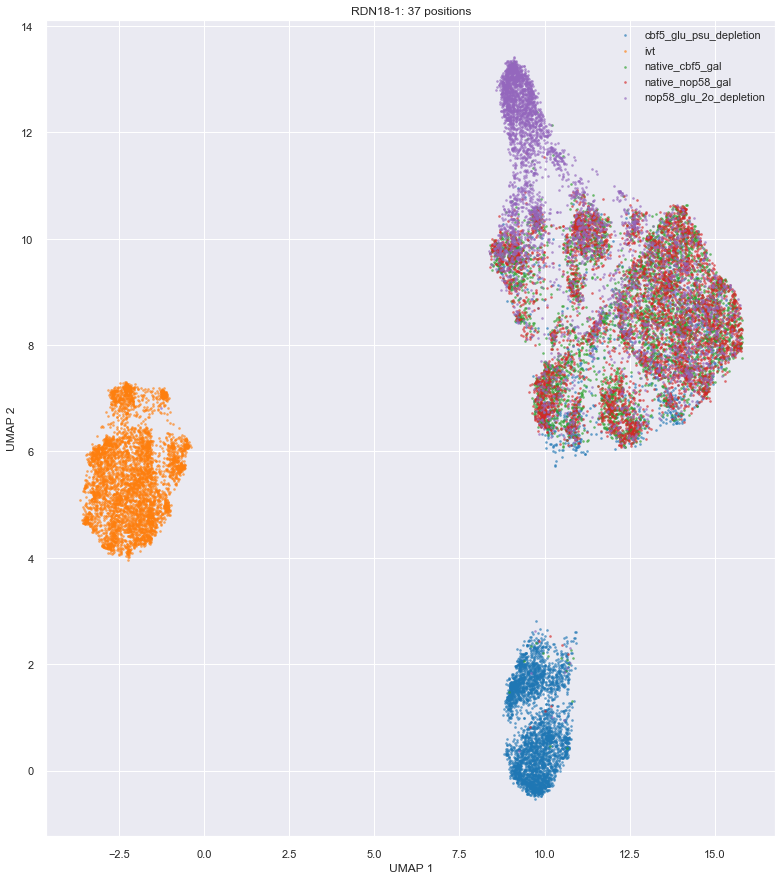

In [275]:
contig = 'RDN18-1'
vc.plot_UMAP_by_label(contig, vc.get_contig_positions(contig))

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

/Users/andrewbailey/anaconda3/envs/read_clustering/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

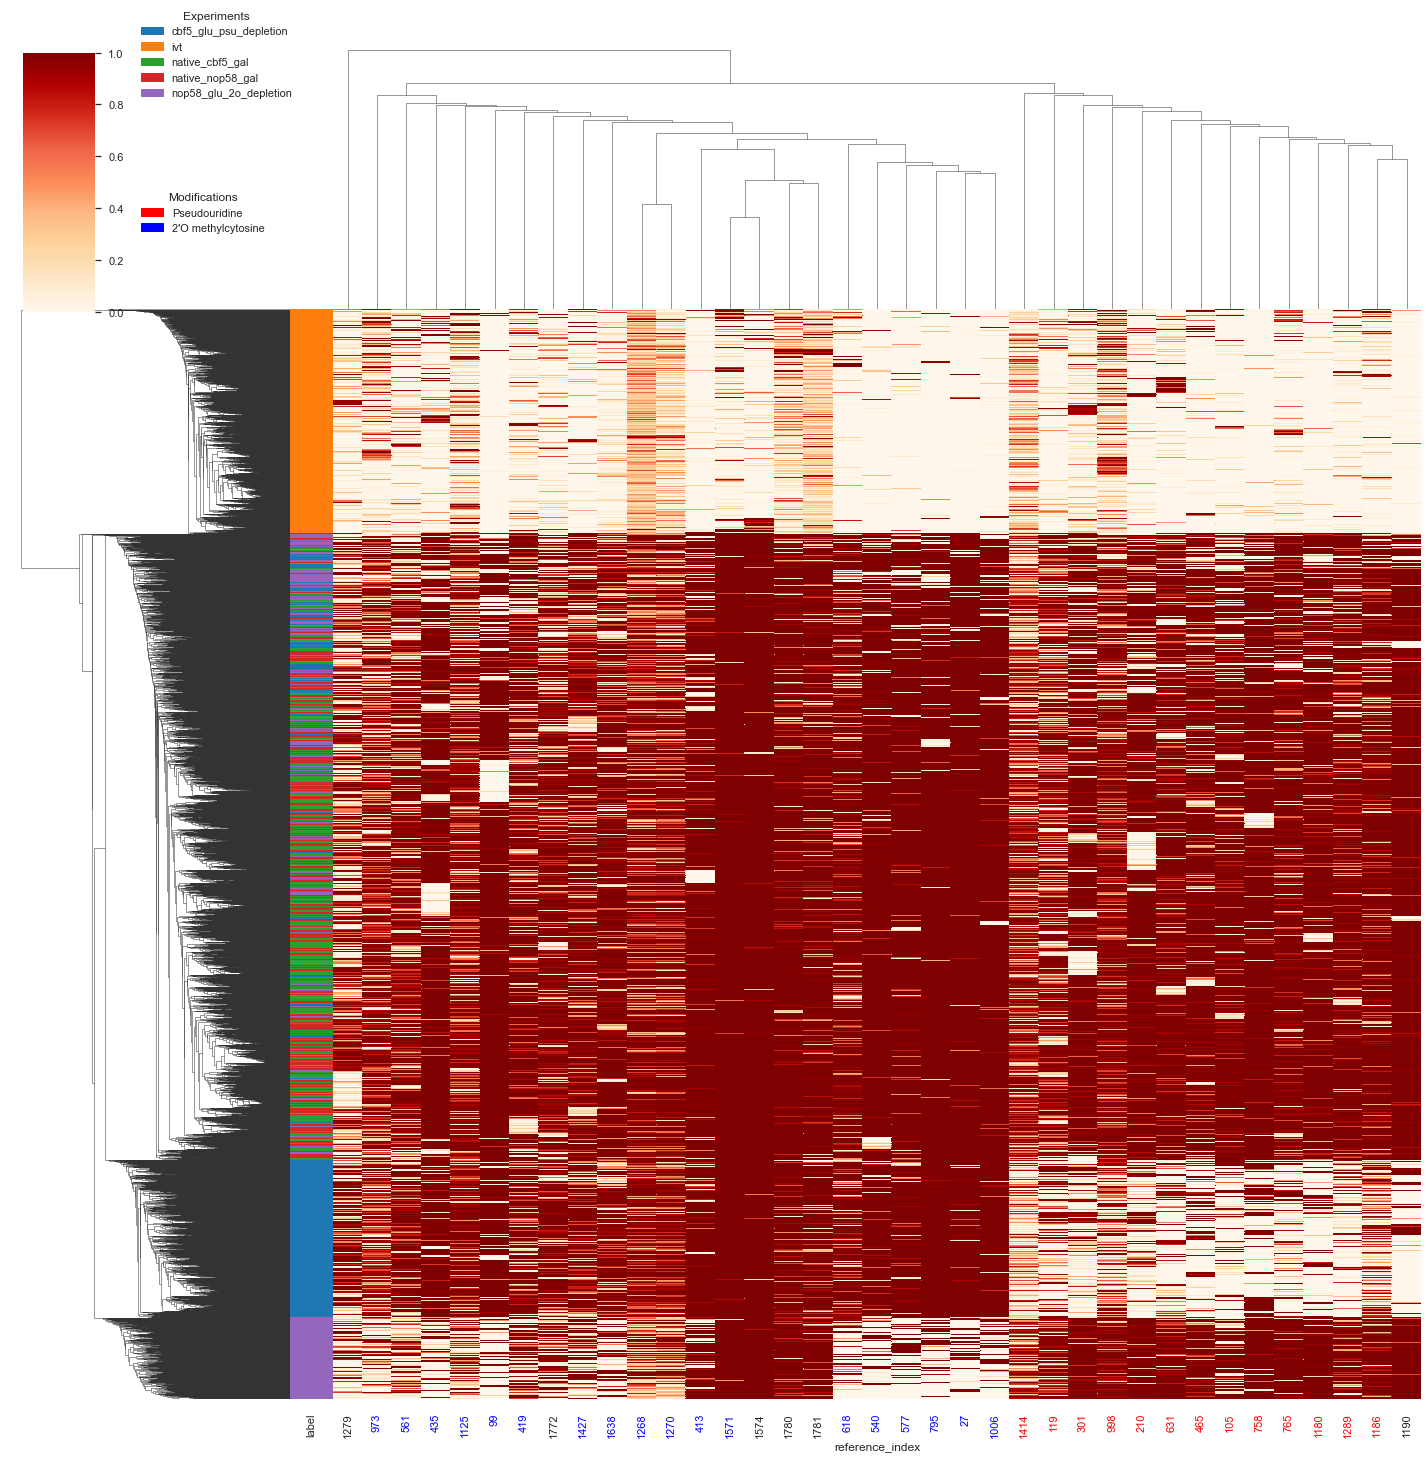

In [277]:
n = -1
vc.plot_heatmap_dendrogram(contig, vc.get_contig_positions(contig), n=n)

/Users/andrewbailey/anaconda3/envs/read_clustering/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/andrewbailey/anaconda3/envs/read_clustering/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


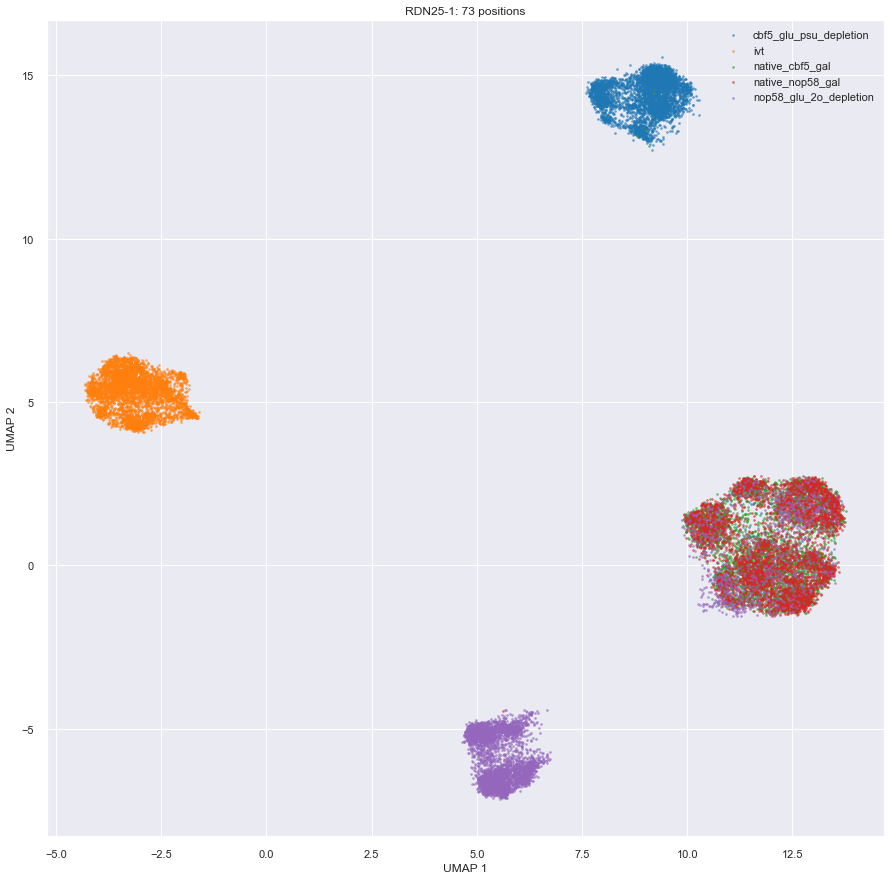

In [17]:
contig = 'RDN25-1'
vc.plot_UMAP_by_label(contig, vc.get_contig_positions(contig))

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

/Users/andrewbailey/anaconda3/envs/read_clustering/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

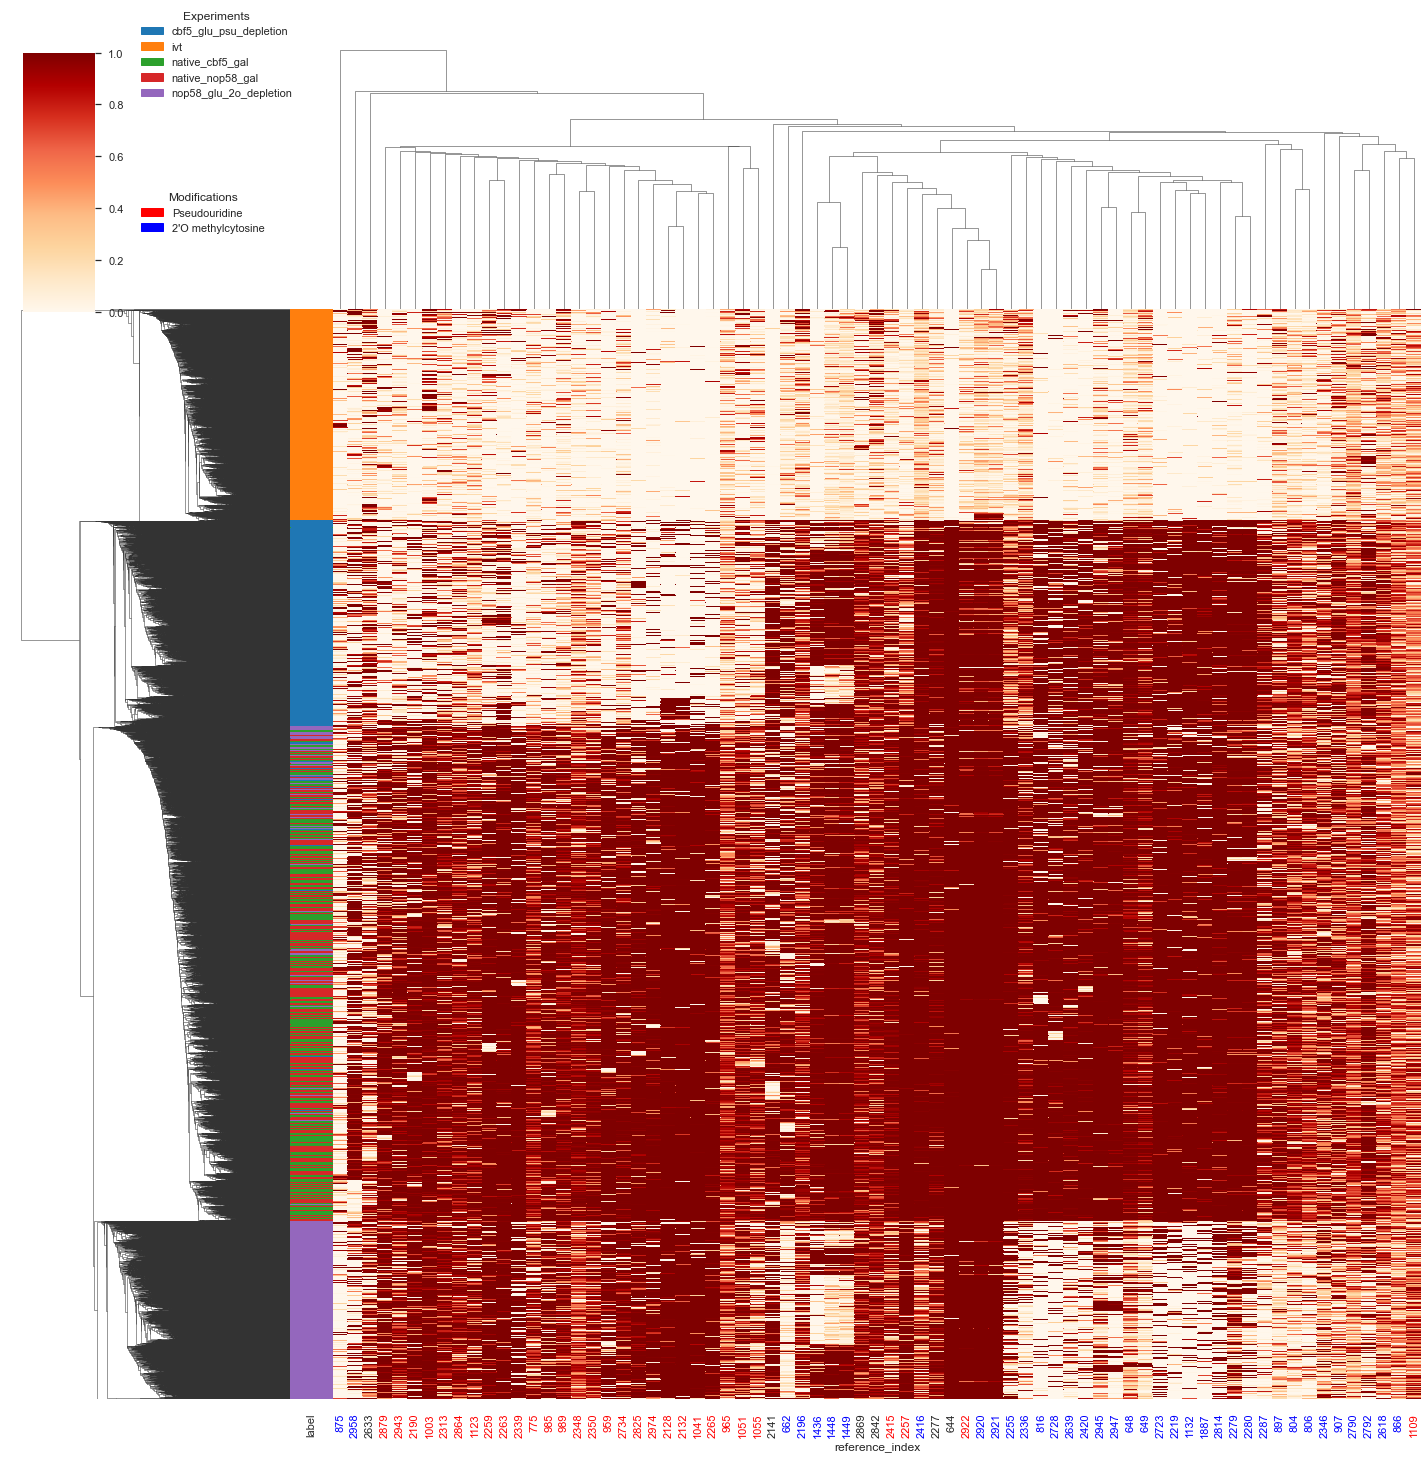

In [18]:
n = -1
vc.plot_heatmap_dendrogram(contig, vc.get_contig_positions(contig), n=n)

In [264]:
file_paths = [native_cbf5_gal_path, native_nop58_gal_path]
labels = ["native_cbf5_gal", "native_nop58_gal"]
vc1 = VariantCalls(file_paths, labels)


/Users/andrewbailey/anaconda3/envs/read_clustering/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/andrewbailey/anaconda3/envs/read_clustering/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


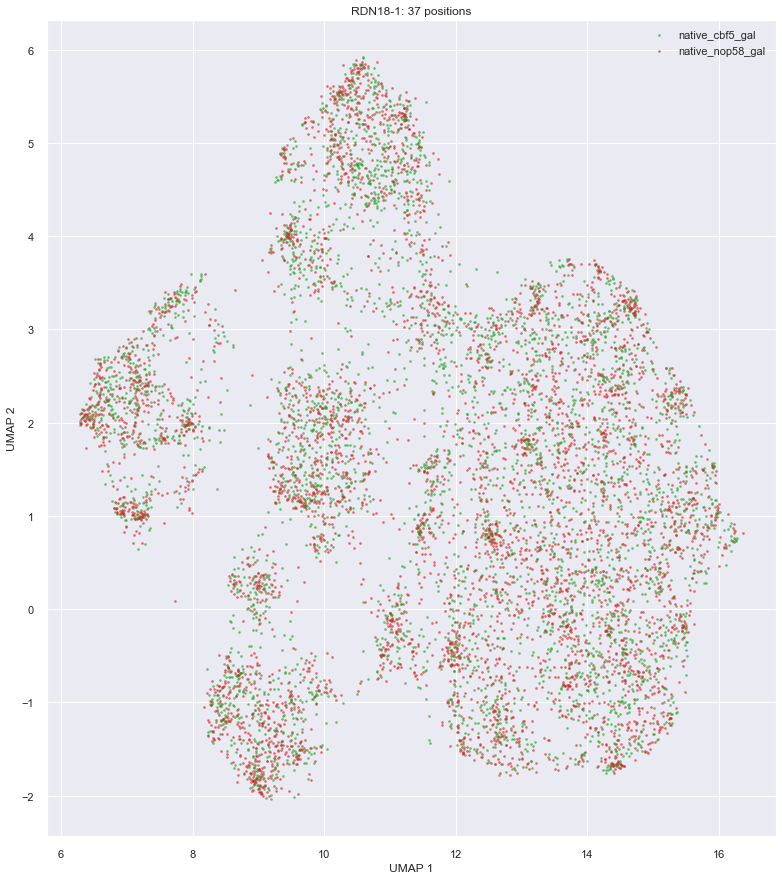

In [265]:
contig = 'RDN18-1'
vc1.plot_UMAP_by_label(contig, vc.get_contig_positions(contig))

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

/Users/andrewbailey/anaconda3/envs/read_clustering/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

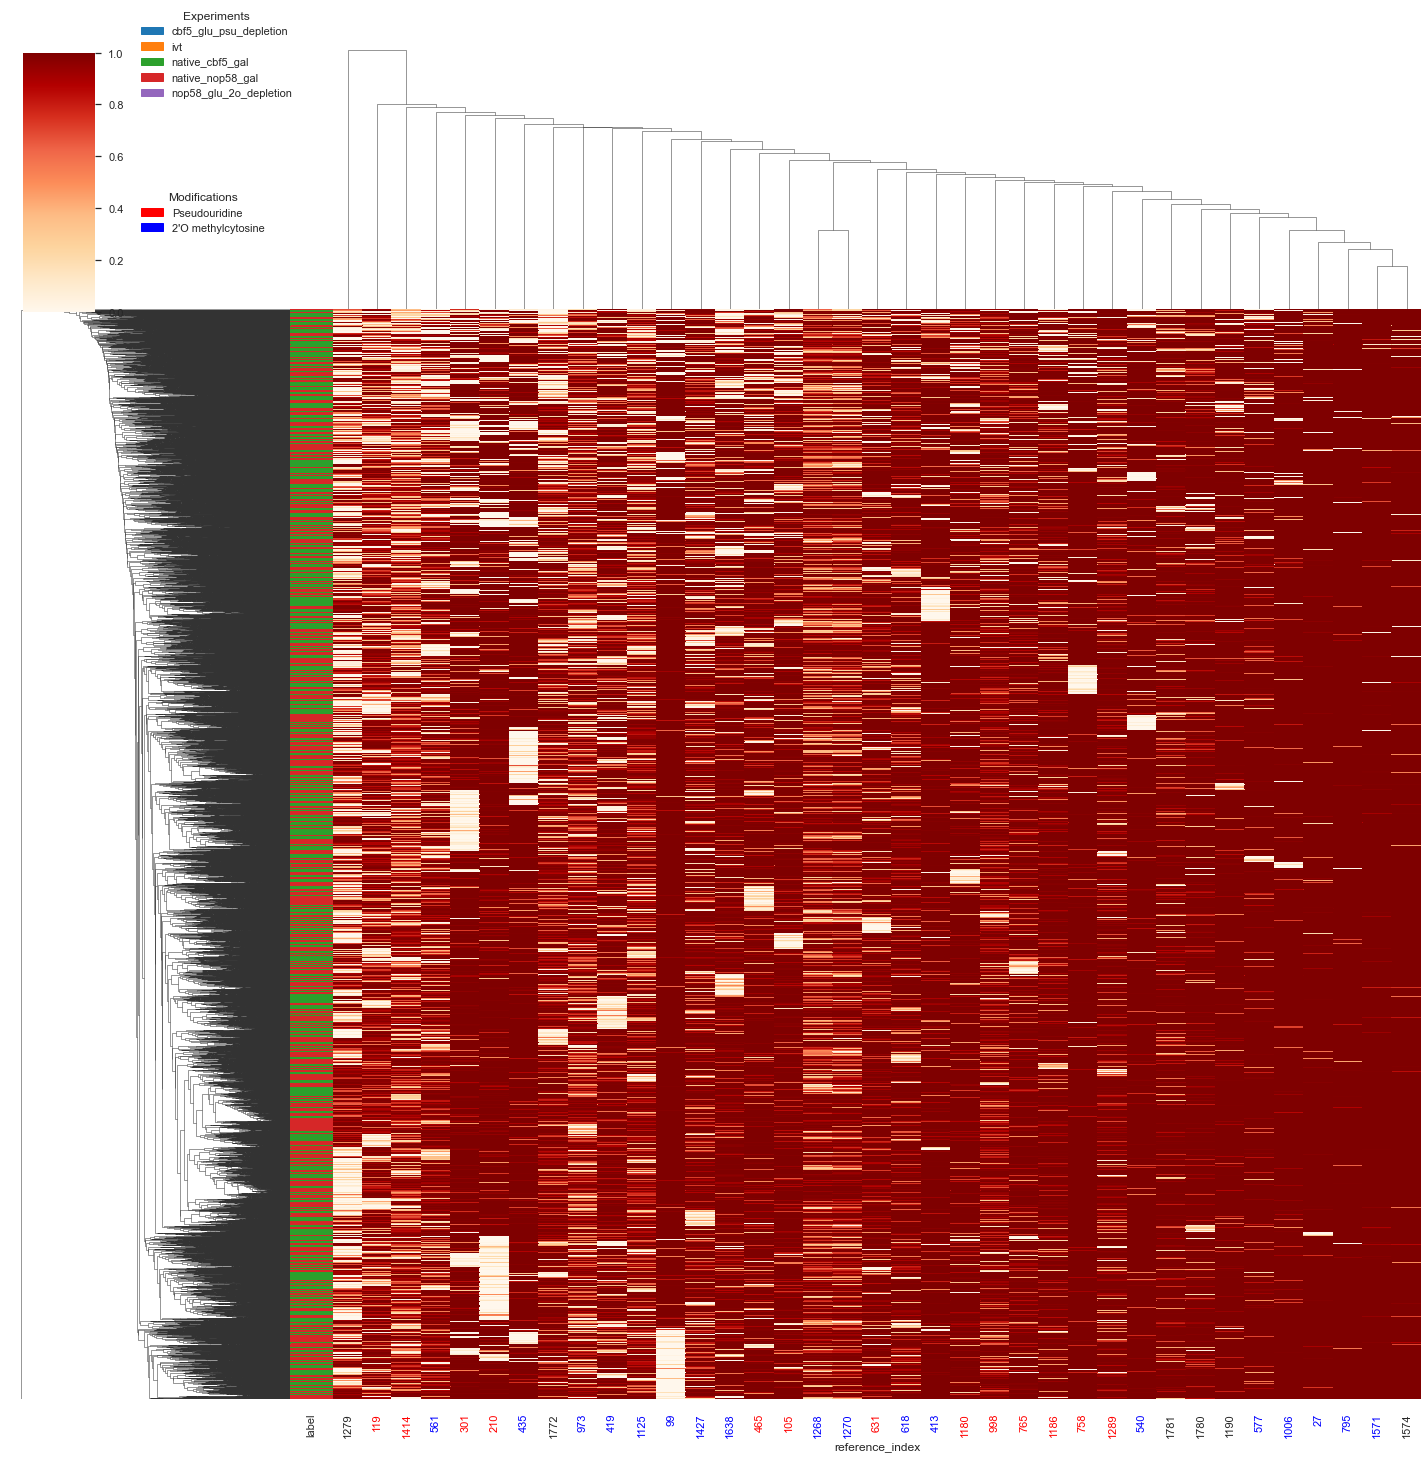

In [266]:
n = -1
vc1.plot_heatmap_dendrogram(contig, vc.get_contig_positions(contig), n=n)

/Users/andrewbailey/anaconda3/envs/read_clustering/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/andrewbailey/anaconda3/envs/read_clustering/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


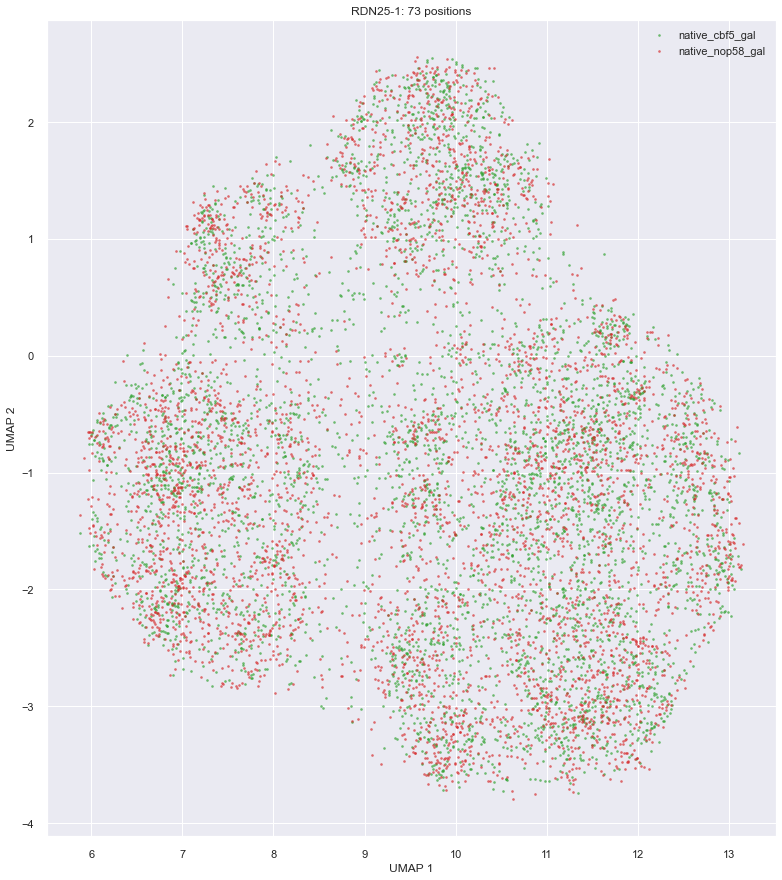

In [267]:
contig = 'RDN25-1'
vc1.plot_UMAP_by_label(contig, vc.get_contig_positions(contig))

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

/Users/andrewbailey/anaconda3/envs/read_clustering/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

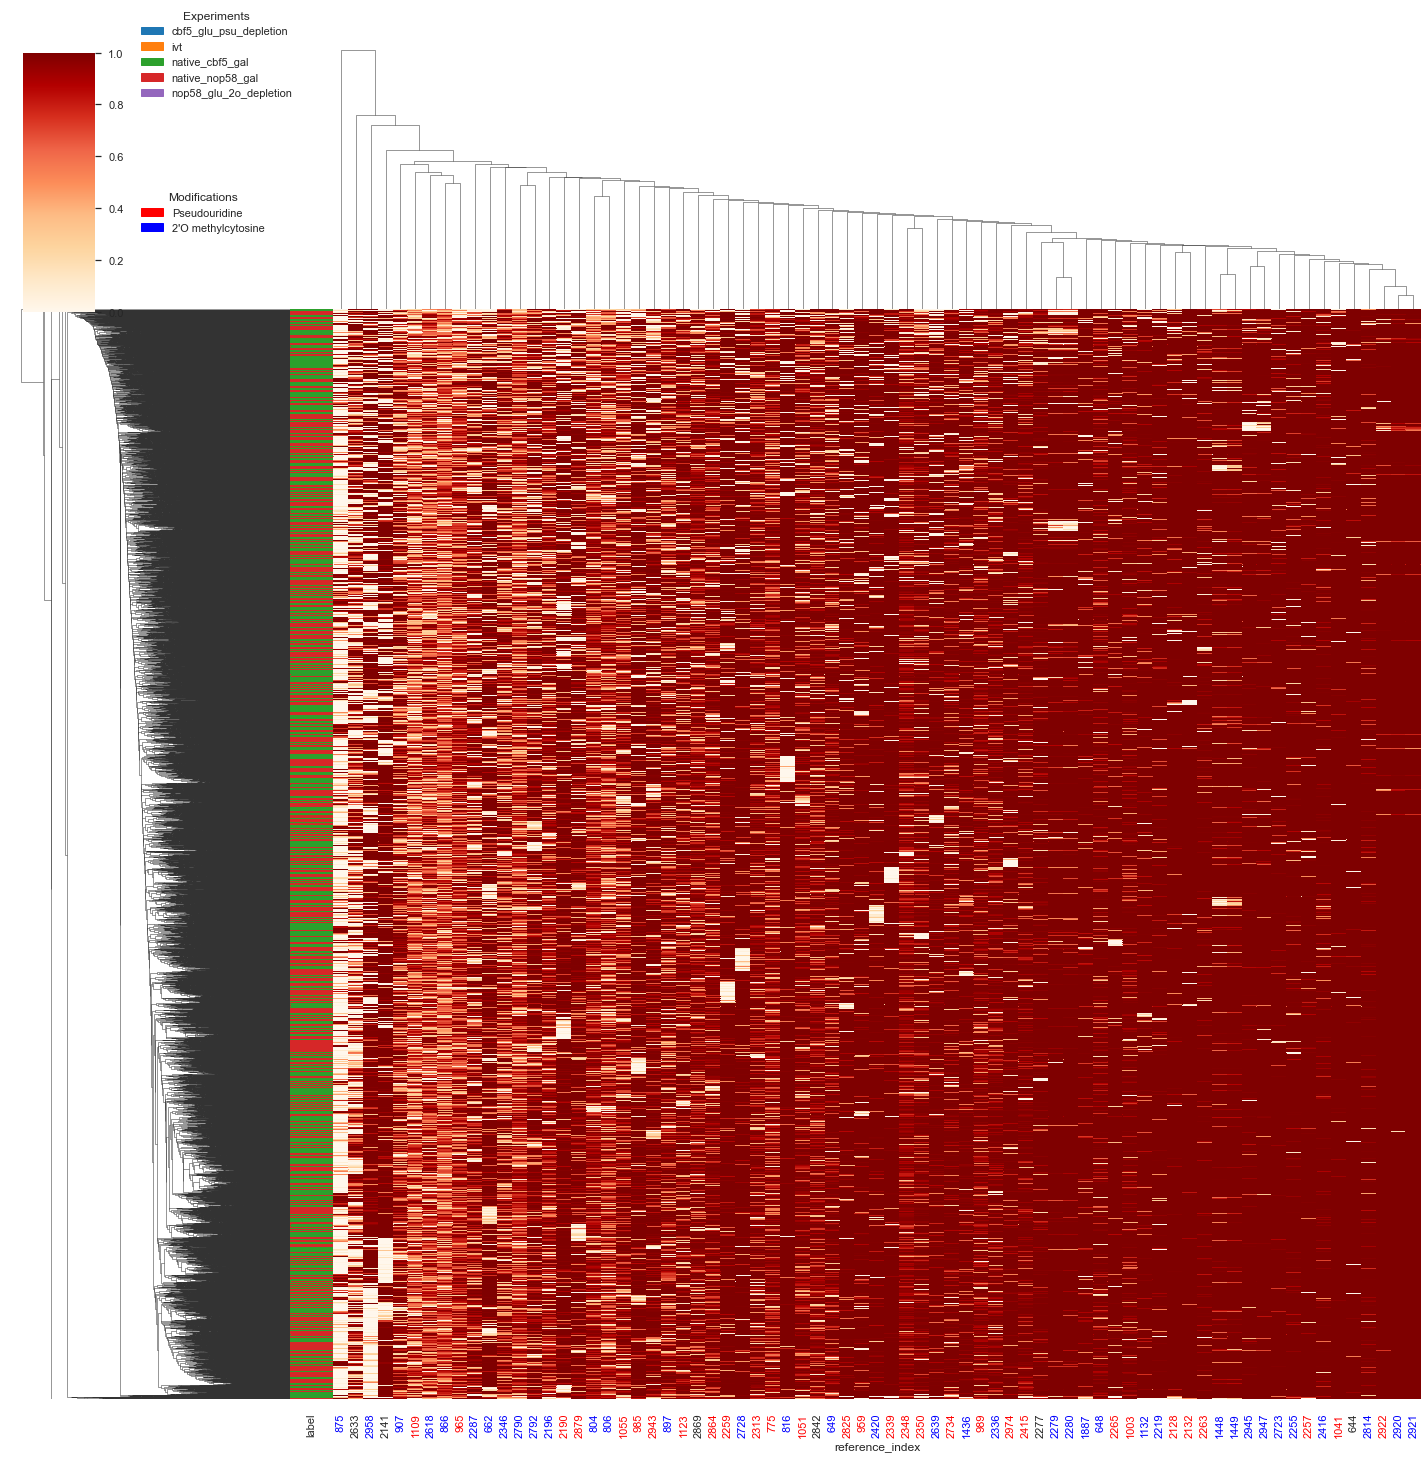

In [268]:
n = -1
vc1.plot_heatmap_dendrogram(contig, vc.get_contig_positions(contig), n=n)

## Generate LD like plot for positions

In [270]:
file_paths = [native_cbf5_gal_path, native_nop58_gal_path]
labels = ["native_cbf5_gal", "native_nop58_gal"]
vc = VariantCalls(file_paths, labels)


In [271]:
cmap = "OrRd"
cmap = "cool"
cmap = "hot"
pseudou="ql"
twoprimeo=["na", "ob", "pc", "qd"]
norm = None
stat = "r2"
# norm = mpl.colors.LogNorm(vmin=.1, vmax=1)
# norm = mpl.colors.Normalize(vmin=0, vmax=0.02)
# norm(0.01)

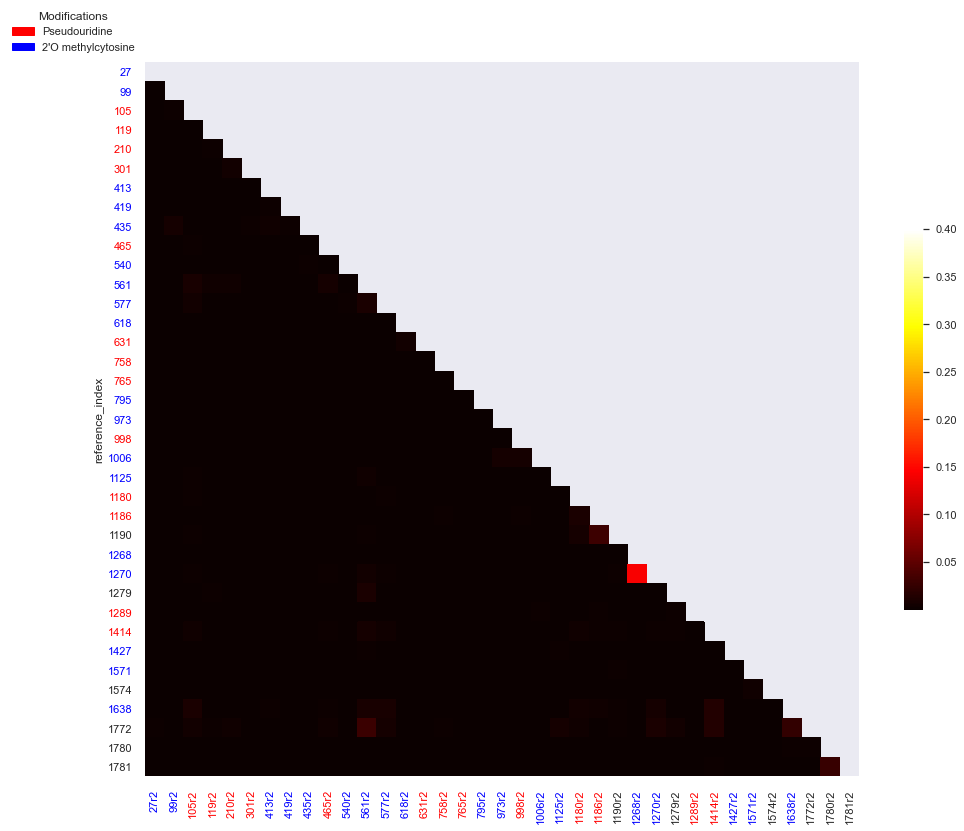

In [272]:
contig = 'RDN18-1'
ld_df = vc.plot_ld_heatmap(contig, vc.get_contig_positions(contig), stat="r2", cmap=cmap, norm=norm)


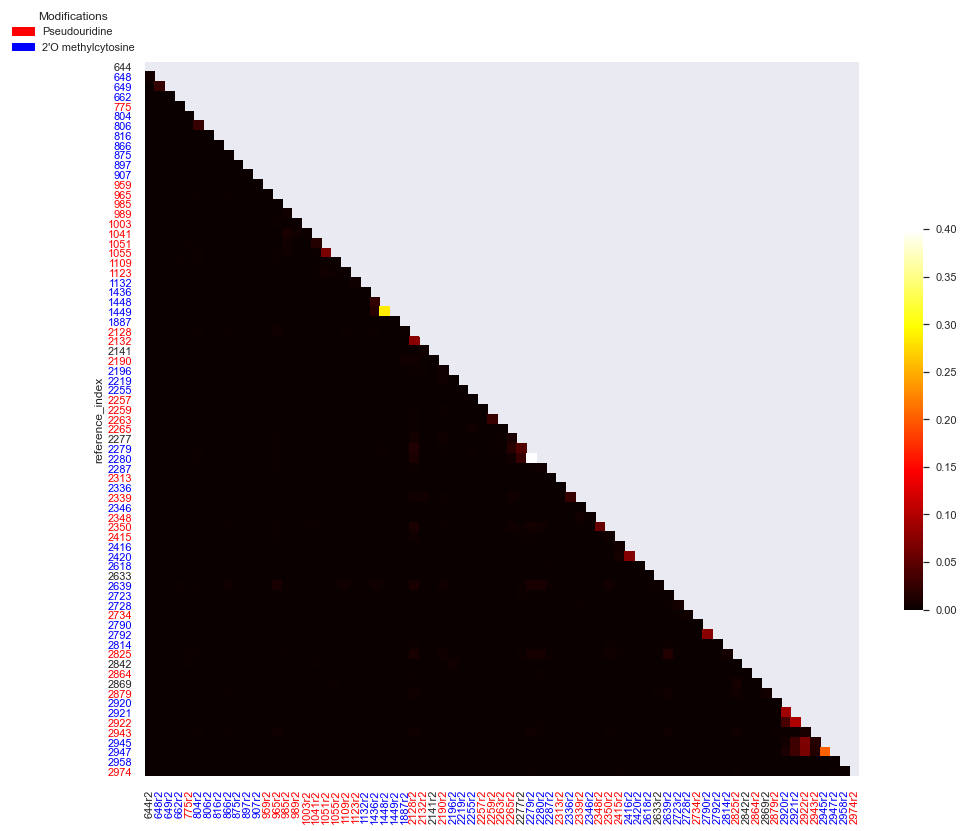

In [273]:
contig = 'RDN25-1'
ld_df = vc.plot_ld_heatmap(contig, vc.get_contig_positions(contig), stat="r2", cmap=cmap, norm=norm)


In [274]:
vc = VariantCalls([ivt_path], ["ivt"])


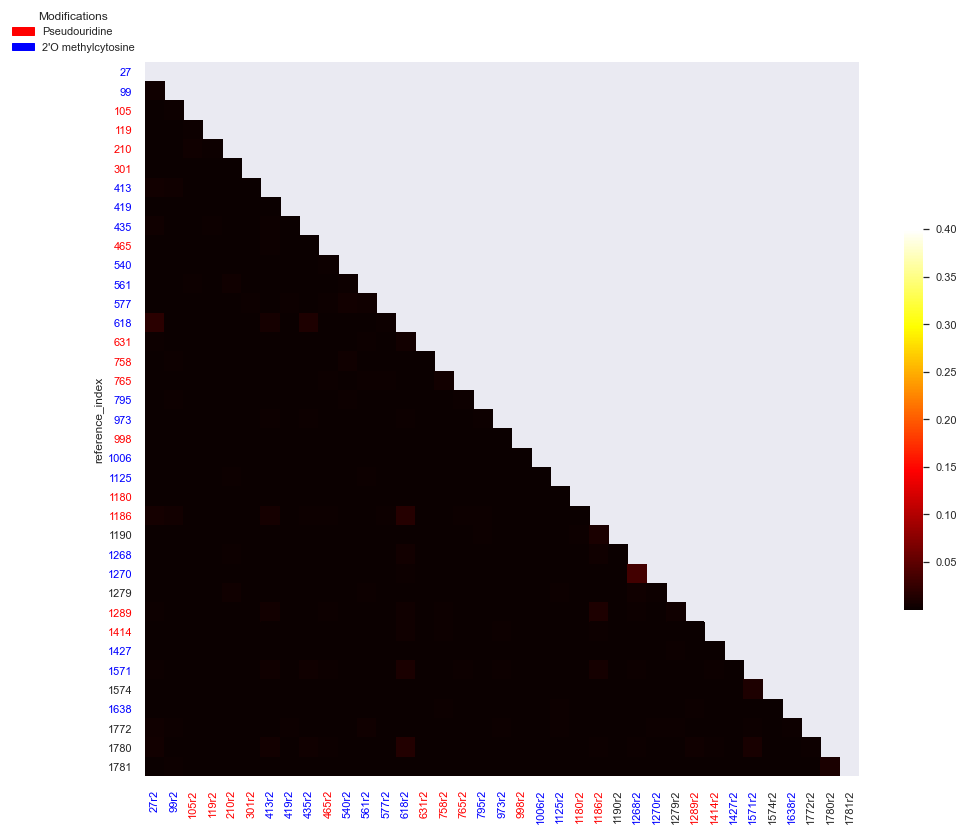

In [275]:
contig = 'RDN18-1'
ld_df = vc.plot_ld_heatmap(contig, vc.get_contig_positions(contig), stat="r2", cmap=cmap, norm=norm)


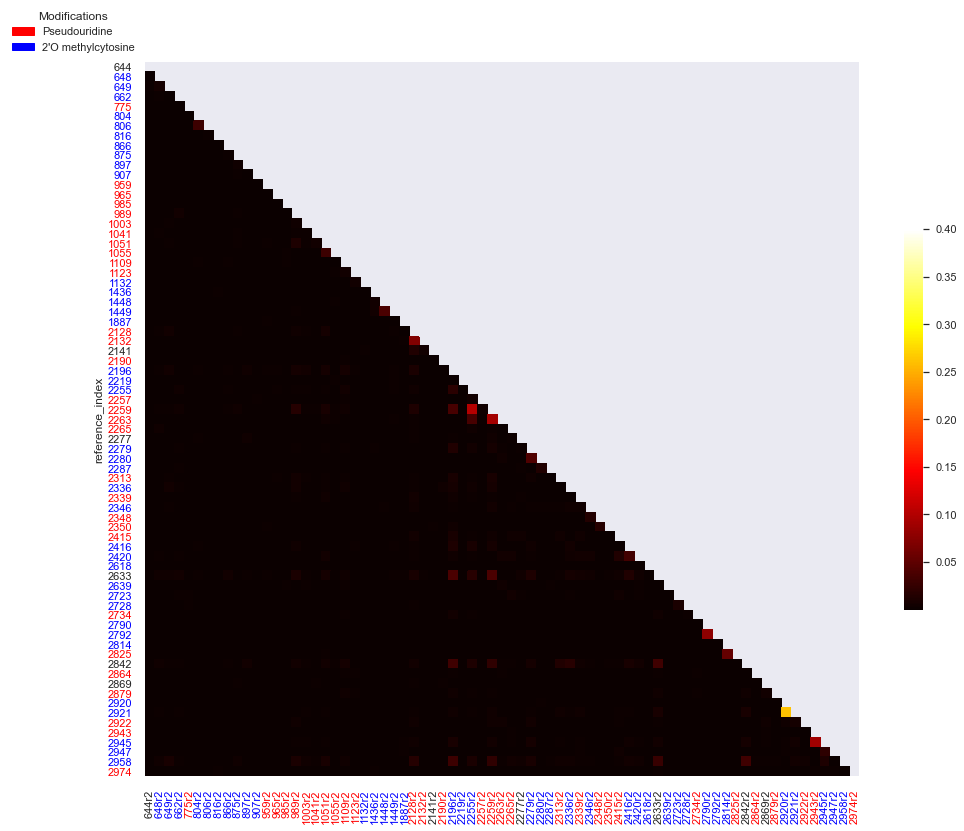

In [276]:
contig = 'RDN25-1'
ld_df = vc.plot_ld_heatmap(contig, vc.get_contig_positions(contig), stat="r2", cmap=cmap, norm=norm)


In [277]:
vc = VariantCalls([cbf5_glu_psu_depletion_path], ["cbf5_glu_psu_depletion"])


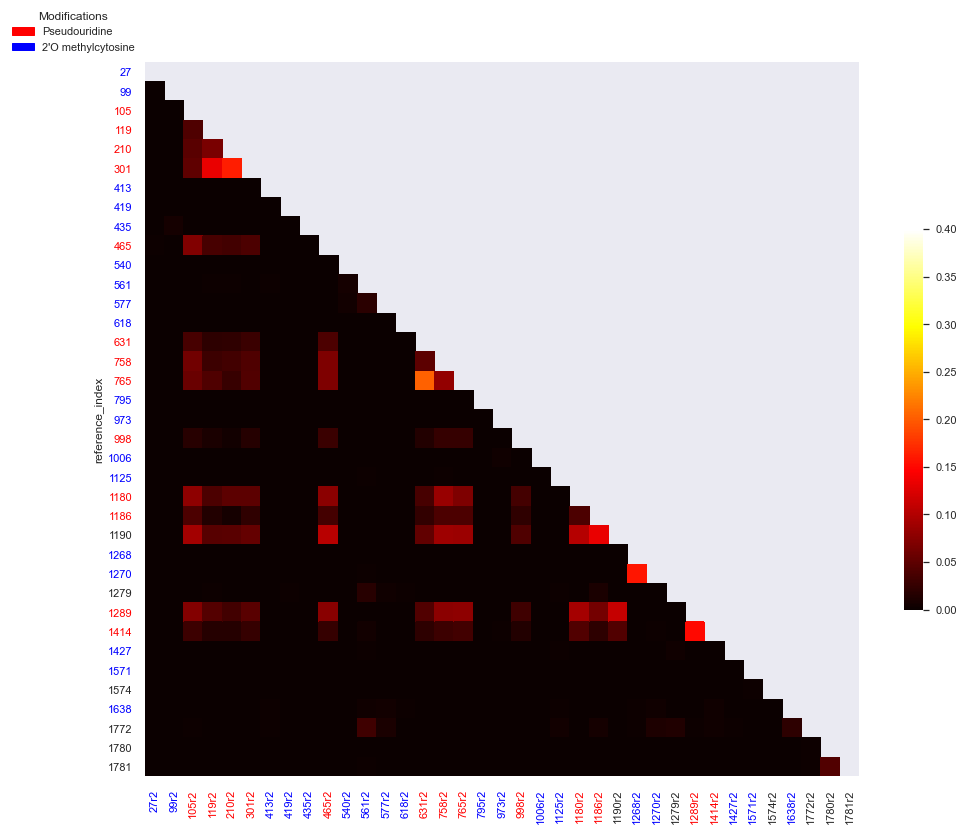

In [278]:
contig = 'RDN18-1'
ld_df = vc.plot_ld_heatmap(contig, vc.get_contig_positions(contig), stat="r2", cmap=cmap, norm=norm)


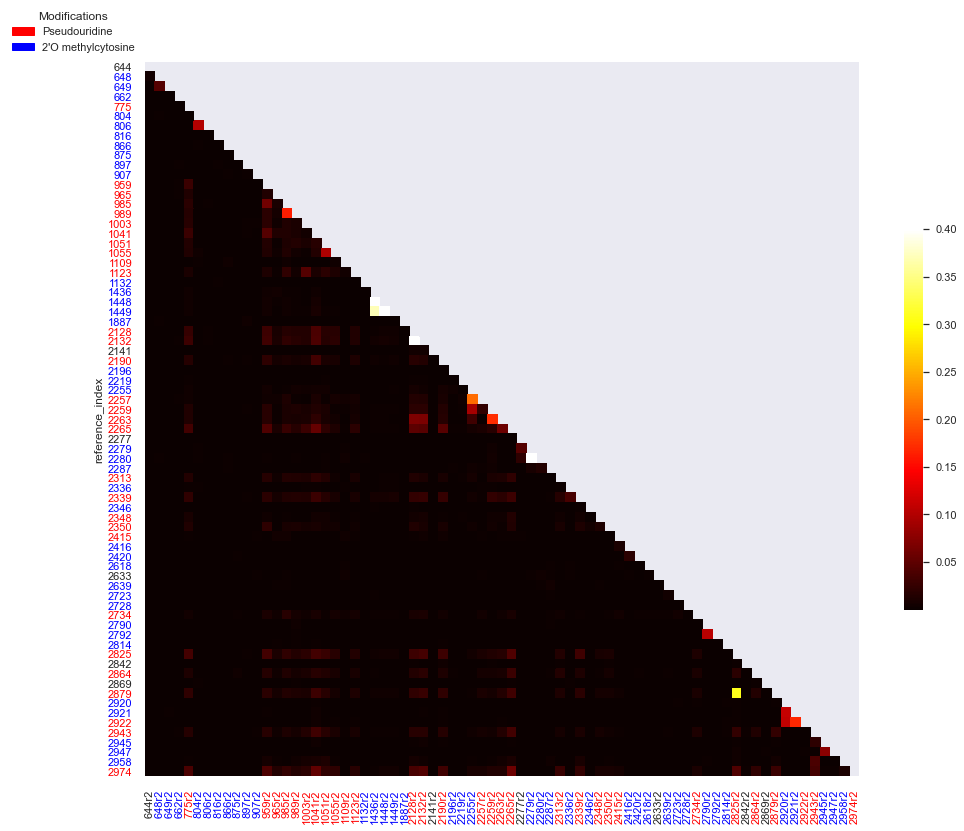

In [279]:
contig = 'RDN25-1'
ld_df = vc.plot_ld_heatmap(contig, vc.get_contig_positions(contig), stat="r2", cmap=cmap, norm=norm)


In [280]:
vc = VariantCalls([nop58_glu_2o_depletion_path], ["nop58_glu_2o_depletion"])


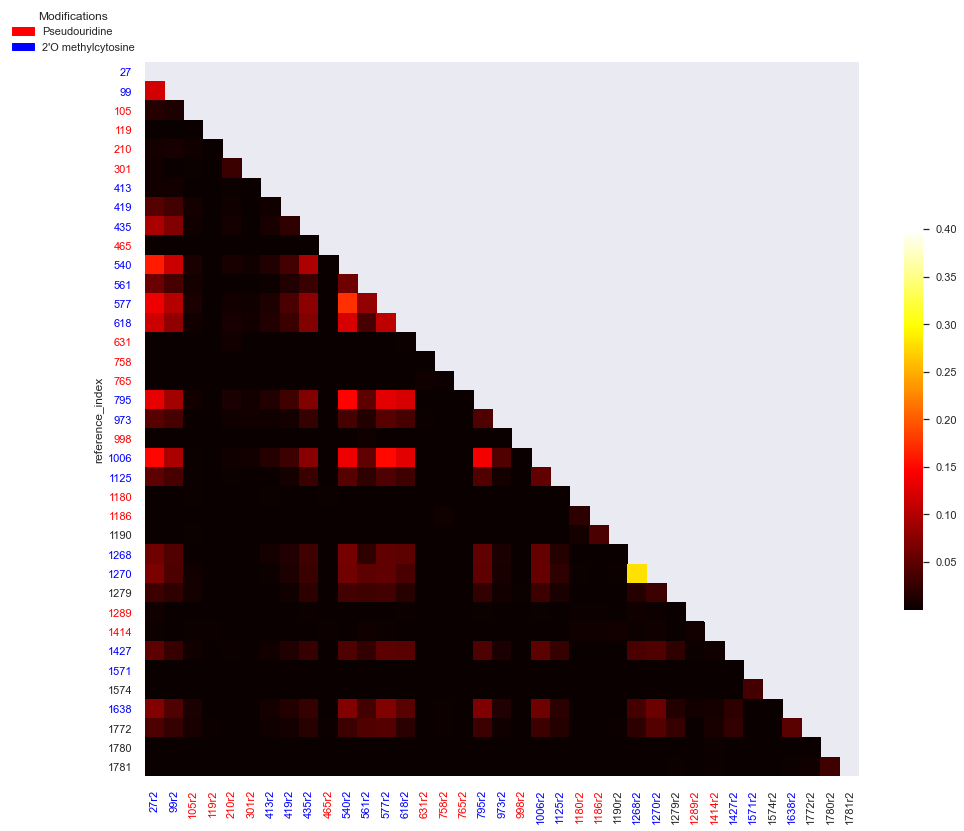

In [281]:
contig = 'RDN18-1'
ld_df = vc.plot_ld_heatmap(contig, vc.get_contig_positions(contig), stat="r2", cmap=cmap, norm=norm)


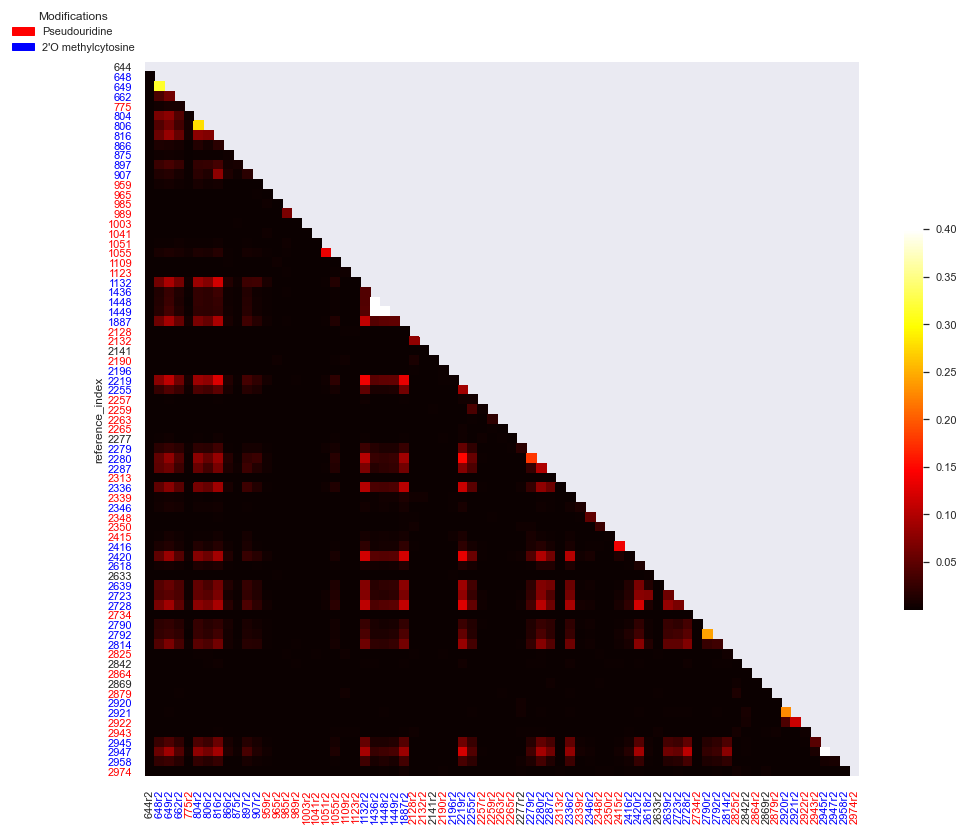

In [282]:
contig = 'RDN25-1'
ld_df = vc.plot_ld_heatmap(contig, vc.get_contig_positions(contig), stat="r2", cmap=cmap, norm=norm)
